In [ ]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

MAX_MEMORY = "12g"

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext

In [ ]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import clustering
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

In [ ]:
train = spark.read.format("csv").option("header", "true").load("train.csv")
test = spark.read.format("csv").option("header", "true").load("test.csv")

In [ ]:
train.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  4|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|  

In [ ]:
train = train.drop('id')
test = test.drop('id')

In [ ]:
train.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Driving_License: string (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Previously_Insured: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: string (nullable = true)
 |-- Policy_Sales_Channel: string (nullable = true)
 |-- Vintage: string (nullable = true)
 |-- Response: string (nullable = true)



In [ ]:
train = train.withColumn("AgeTemp", train["Age"].cast("double")).drop("Age").withColumnRenamed("AgeTemp", "Age")
train = train.withColumn("DrivingTemp", train["Driving_License"].cast("double")).drop("Driving_License").withColumnRenamed("DrivingTemp", "Driving_License")
train = train.withColumn("Previously_InsuredTemp", train["Previously_Insured"].cast("double")).drop("Previously_Insured").withColumnRenamed("Previously_InsuredTemp", "Previously_Insured")
train = train.withColumn("Annual_PremiumTemp", train["Annual_Premium"].cast("double")).drop("Annual_Premium").withColumnRenamed("Annual_PremiumTemp", "Annual_Premium")
train = train.withColumn("Policy_Sales_ChannelTemp", train["Policy_Sales_Channel"].cast("double")).drop("Policy_Sales_Channel").withColumnRenamed("Policy_Sales_ChannelTemp", "Policy_Sales_Channel")
train = train.withColumn("VintageTemp", train["Vintage"].cast("double")).drop("Vintage").withColumnRenamed("VintageTemp", "Vintage")
train = train.withColumn("ResponseTemp", train["Response"].cast("double")).drop("Response").withColumnRenamed("ResponseTemp", "Response")


In [ ]:
train = train.withColumn("Region_CodeTemp", train["Region_Code"].cast("double")).drop("Region_Code").withColumnRenamed("Region_CodeTemp", "Region_Code")

In [ ]:
train = train.withColumn("ResponseTemp", train["Response"].cast("double")).drop("Response").withColumnRenamed("ResponseTemp", "Response")

In [ ]:
train.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Driving_License: double (nullable = true)
 |-- Previously_Insured: double (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: double (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Response: double (nullable = true)



In [ ]:
train.select('Region_Code').distinct().show()
train.select('Vehicle_Age').distinct().show()

+-----------+
|Region_Code|
+-----------+
|        8.0|
|        0.0|
|        7.0|
|       49.0|
|       29.0|
|       47.0|
|       42.0|
|       44.0|
|       35.0|
|       18.0|
|       39.0|
|        1.0|
|       37.0|
|       34.0|
|       25.0|
|       36.0|
|       41.0|
|        4.0|
|       23.0|
|       50.0|
+-----------+
only showing top 20 rows

+-----------+
|Vehicle_Age|
+-----------+
|  > 2 Years|
|   < 1 Year|
|   1-2 Year|
+-----------+



In [ ]:
hist = train.crosstab('Policy_Sales_Channel', 'Response')
hist = hist.withColumn("Policy_Sales_ChannelTemp", hist["Policy_Sales_Channel_Response"].cast("double")).drop("olicy_Sales_Channel_Response").withColumnRenamed("olicy_Sales_Channel_ResponseTemp", "olicy_Sales_Channel_Response")
hist = hist.withColumn("0.0Temp", hist['`0.0`'].cast("double")).drop('`0.0`').withColumnRenamed("0.0Temp", '`0.0`')
hist = hist.withColumn("1.0Temp", hist['`1.0`'].cast("double")).drop('`1.0`').withColumnRenamed("1.0Temp", '`1.0`')

In [ ]:
hist = train.crosstab('Policy_Sales_Channel', 'Response')

In [ ]:
hist = hist.toPandas()

In [ ]:
display(hist)

,Policy_Sales_Channel_Response,0.0,1.0
0,69.0,5,1
1,138.0,112,12
2,101.0,5,2
3,88.0,32,2
4,115.0,4,0
...,...,...,...
150,90.0,19,7
151,111.0,59,9
152,122.0,8210,1720
153,83.0,4,0


In [ ]:
width = 0.5      
plt.bar(hist.Policy_Sales_ChannelTemp, np.log(hist['`0.0`']), width, label='0')
plt.bar(hist.Policy_Sales_ChannelTemp + width, np.log(hist['`1.0`']), width,
    label='1')

plt.ylabel('Scores')
plt.title('Scores by group and gender')

plt.legend(loc='best')
plt.show()

AttributeError: ignored

In [ ]:
train = train.drop('Region_Code')

In [ ]:
train.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Driving_License: double (nullable = true)
 |-- Previously_Insured: double (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: double (nullable = true)
 |-- Response: double (nullable = true)



In [ ]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['Yes', 'No'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

vintage_bin = feature.QuantileDiscretizer(inputCol='Vintage', outputCol='vintage_bin',numBuckets= 3)

feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si,vintage_bin])

train_xformed = feature_engineering_pipe.fit(train).transform(train).drop('Gender','Vehicle_Age','Vehicle_Damage','Vintage').withColumnRenamed("indexedGender",'Gender').withColumnRenamed("indexedVehicle_Age",'Vehicle_Age').withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage').withColumnRenamed('vintage_bin','Vintage')

train_xformed.show()


+----+---------------+------------------+--------------+--------------------+--------+------+-----------+--------------+-------+
| Age|Driving_License|Previously_Insured|Annual_Premium|Policy_Sales_Channel|Response|Gender|Vehicle_Age|Vehicle_Damage|Vintage|
+----+---------------+------------------+--------------+--------------------+--------+------+-----------+--------------+-------+
|44.0|            1.0|               0.0|       40454.0|                26.0|     1.0|   0.0|        2.0|           0.0|    2.0|
|76.0|            1.0|               0.0|       33536.0|                26.0|     0.0|   0.0|        1.0|           1.0|    1.0|
|47.0|            1.0|               0.0|       38294.0|                26.0|     1.0|   0.0|        2.0|           0.0|    0.0|
|21.0|            1.0|               1.0|       28619.0|               152.0|     0.0|   0.0|        0.0|           1.0|    2.0|
|29.0|            1.0|               1.0|       27496.0|               152.0|     0.0|   1.0|    

In [ ]:
train_xformed.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Driving_License: double (nullable = true)
 |-- Previously_Insured: double (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Response: double (nullable = true)
 |-- Gender: double (nullable = false)
 |-- Vehicle_Age: double (nullable = false)
 |-- Vehicle_Damage: double (nullable = false)
 |-- Vintage: double (nullable = true)



In [ ]:
numerical_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['Age','Annual_Premium' ,'Policy_Sales_Channel'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures")])

In [ ]:

all_features = Pipeline(stages=[numerical_features,
                               feature.VectorAssembler(inputCols=['scaledFeatures','Driving_License','Gender','Vehicle_Age','Vehicle_Damage','Previously_Insured','Vintage'],outputCol = 'features')
                               ])

In [ ]:
lr = classification.LogisticRegression(labelCol='Response')

In [ ]:
final_model_pipeline = Pipeline(stages=[all_features, lr])

In [ ]:
train_df, validation_df = train_xformed.randomSplit([0.9, 0.1], 42)

In [ ]:
initial_model = final_model_pipeline.fit(train_df)

In [ ]:
print("Coefficients: " + str(initial_model.stages[-1].coefficients))
print("Intercept: " + str(initial_model.stages[-1].intercept))

Coefficients: [-0.30846465716569577,0.027676955088298153,-0.15535355961893196,1.3890492967533938,-0.10060276032856176,0.6868762090925543,-2.0304463831977753,-3.981621134242091,3.9042700884696076e-05]
Intercept: -1.9625784416551981


In [ ]:
predictions = initial_model.transform(validation_df)

In [ ]:
evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')

In [ ]:
print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))

Validation AreaUnderPR 0.32853003946014275


In [ ]:
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8736436730764227


In [ ]:
predictions.show()

In [ ]:
features = ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Driving_License','Gender','Vehicle_Age','Vehicle_Damage','Previously_Insured','Vintage' ]


In [ ]:
coefficients = initial_model.stages[-1].coefficients

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

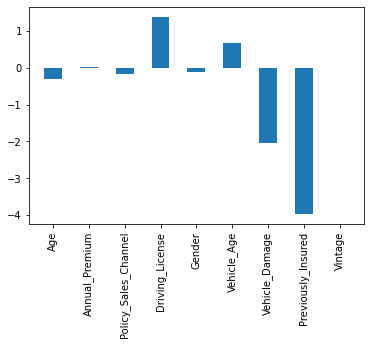

In [ ]:
plt.bar(features, coefficients, width, label='0')
plt.xticks(rotation=90)

In [ ]:
train.describe().show()

+-------+------+-----------+--------------+------------------+-------------------+-------------------+------------------+--------------------+------------------+-------------------+
|summary|Gender|Vehicle_Age|Vehicle_Damage|               Age|    Driving_License| Previously_Insured|    Annual_Premium|Policy_Sales_Channel|           Vintage|           Response|
+-------+------+-----------+--------------+------------------+-------------------+-------------------+------------------+--------------------+------------------+-------------------+
|  count|381109|     381109|        381109|            381109|             381109|             381109|            381109|              381109|            381109|             381109|
|   mean|  null|       null|          null|38.822583565331705| 0.9978693759528114| 0.4582101183650871|30564.389581458323|  112.03429465061177|154.34739667654136|0.12256336113815208|
| stddev|  null|       null|          null|15.511611018095289|0.04610954420779939|0.498251

Text(0.5, 0, 'vintage')

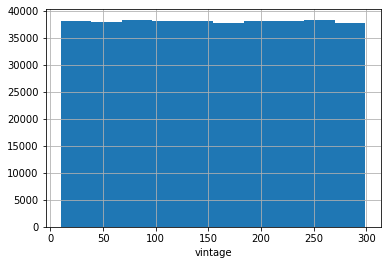

In [ ]:
train.toPandas().Vintage.hist()
plt.xlabel('vintage')

Text(0.5, 0, 'vintage')

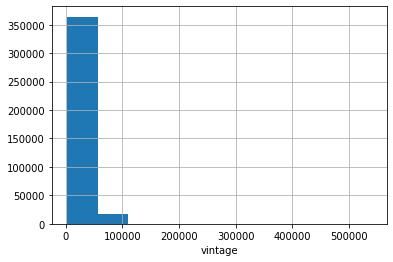

In [ ]:
train.toPandas().Annual_Premium.hist()
plt.xlabel('vintage')

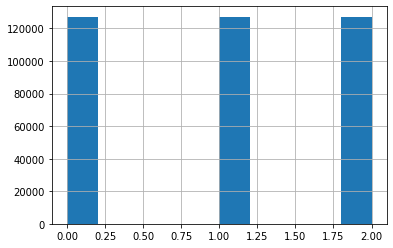

In [ ]:
feature.QuantileDiscretizer(numBuckets=3, inputCol='Annual_Premium', outputCol='premium_bins').fit(train).transform(train).toPandas().iloc[:, -1].hist()

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)

In [ ]:
final_model_fitted = crossval.fit(train_df)

In [ ]:
evaluator.evaluate(final_model_fitted.transform(validation_df))

In [ ]:
coefficients = final_model_fitted.bestModel.stages[-1].coefficients

In [ ]:
plt.bar(features, coefficients, width, label='0')
plt.xticks(rotation=90)

In [ ]:
predictions = final_model_fitted.transform(validation_df)
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

In [ ]:
explo = train.toPandas()

+----+---------------+------------------+--------------+--------------------+-------+--------+------+-----------+--------------+
| Age|Driving_License|Previously_Insured|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Gender|Vehicle_Age|Vehicle_Damage|
+----+---------------+------------------+--------------+--------------------+-------+--------+------+-----------+--------------+
|44.0|            1.0|               0.0|       40454.0|                26.0|  217.0|     1.0|   0.0|        2.0|           0.0|
|76.0|            1.0|               0.0|       33536.0|                26.0|  183.0|     0.0|   0.0|        1.0|           1.0|
|47.0|            1.0|               0.0|       38294.0|                26.0|   27.0|     1.0|   0.0|        2.0|           0.0|
|21.0|            1.0|               1.0|       28619.0|               152.0|  203.0|     0.0|   0.0|        0.0|           1.0|
|29.0|            1.0|               1.0|       27496.0|               152.0|   39.0|     0.0|   

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

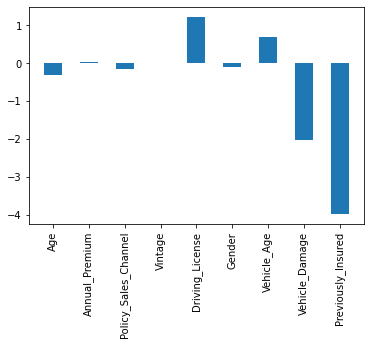

In [ ]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['Yes', 'No'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

#vintage_bin = feature.QuantileDiscretizer(inputCol='Vintage', outputCol='vintage_bin',numBuckets= 3)

feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si])

train_xformed = feature_engineering_pipe.fit(train).transform(train).drop('Gender','Vehicle_Age','Vehicle_Damage').withColumnRenamed("indexedGender",'Gender').withColumnRenamed("indexedVehicle_Age",'Vehicle_Age').withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage')

train_xformed.show()

numerical_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['Age','Annual_Premium' ,'Policy_Sales_Channel','Vintage'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures")])


all_features = Pipeline(stages=[numerical_features,
                               feature.VectorAssembler(inputCols=['scaledFeatures','Driving_License','Gender','Vehicle_Age','Vehicle_Damage','Previously_Insured'],outputCol = 'features')
                               ])

lr = classification.LogisticRegression(labelCol='Response')
final_model_pipeline = Pipeline(stages=[all_features, lr])
train_df, validation_df = train_xformed.randomSplit([0.9, 0.1], 42)
initial_model = final_model_pipeline.fit(train_df)
print("Coefficients: " + str(initial_model.stages[-1].coefficients))
print("Intercept: " + str(initial_model.stages[-1].intercept))
predictions = initial_model.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')
print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)
features = ['Age', 'Annual_Premium', 'Policy_Sales_Channel','Vintage', 'Driving_License','Gender','Vehicle_Age','Vehicle_Damage','Previously_Insured']
coefficients = initial_model.stages[-1].coefficients
plt.bar(features, coefficients, width, label='0')
plt.xticks(rotation=90)

+----+---------------+------------------+--------------+-------+--------+------+-----------+--------------+--------------------+---------------+
| Age|Driving_License|Previously_Insured|Annual_Premium|Vintage|Response|Gender|Vehicle_Age|Vehicle_Damage|Policy_Sales_Channel|    Region_Code|
+----+---------------+------------------+--------------+-------+--------+------+-----------+--------------+--------------------+---------------+
|44.0|            1.0|               0.0|       40454.0|  217.0|     1.0|   0.0|        2.0|           1.0|     (154,[1],[1.0])| (52,[0],[1.0])|
|76.0|            1.0|               0.0|       33536.0|  183.0|     0.0|   0.0|        1.0|           0.0|     (154,[1],[1.0])| (52,[8],[1.0])|
|47.0|            1.0|               0.0|       38294.0|   27.0|     1.0|   0.0|        2.0|           1.0|     (154,[1],[1.0])| (52,[0],[1.0])|
|21.0|            1.0|               1.0|       28619.0|  203.0|     0.0|   0.0|        0.0|           0.0|     (154,[0],[1.0])| (

ValueError: ignored

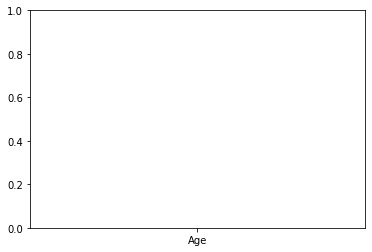

In [ ]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['No', 'Yes'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

policy_si = feature.StringIndexer(inputCol='Policy_Sales_Channel', outputCol='policy_col2', handleInvalid='skip')
policy_one_hot = feature.OneHotEncoder(inputCol='policy_col2',outputCol = "One Hot Policy")

region_si = feature.StringIndexer(inputCol='Region_Code', outputCol='region_col2', handleInvalid='skip')
region_one_hot = feature.OneHotEncoder(inputCol='region_col2',outputCol = "One Hot Region")


feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si,policy_si,policy_one_hot,region_si,region_one_hot])

train_xformed = feature_engineering_pipe.fit(train).transform(train).drop('Gender','Vehicle_Age','Vehicle_Damage','policy_col2','Policy_Sales_Channel','Region_Code','region_col2').withColumnRenamed("indexedGender",'Gender').withColumnRenamed("indexedVehicle_Age",'Vehicle_Age').withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage').withColumnRenamed("One Hot Policy",'Policy_Sales_Channel').withColumnRenamed("One Hot Region",'Region_Code')

train_xformed.show()

numerical_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['Age','Annual_Premium' ,'Policy_Sales_Channel','Vintage','Region_Code'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures")])


all_features = Pipeline(stages=[numerical_features,
                               feature.VectorAssembler(inputCols=['scaledFeatures','Driving_License','Gender','Vehicle_Age','Vehicle_Damage','Previously_Insured'],outputCol = 'features')
                               ])

lr = classification.LogisticRegression(labelCol='Response')
final_model_pipeline = Pipeline(stages=[all_features, lr])
train_df, validation_df = train_xformed.randomSplit([0.9, 0.1], 42)
initial_model = final_model_pipeline.fit(train_df)
print("Coefficients: " + str(initial_model.stages[-1].coefficients))
print("Intercept: " + str(initial_model.stages[-1].intercept))
predictions = initial_model.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')
print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)

In [ ]:
final_model_fitted = crossval.fit(train_df)

In [ ]:
evaluator.evaluate(final_model_fitted.transform(validation_df))

0.33835627138054775

In [ ]:
predictions = final_model_fitted.transform(validation_df)
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8752049127006843
